In [23]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Using our merged dataset train & test data

This Task is (SEB VS NEVUS). PLEASE USE APPROPRIATE PATH TO TASK

In [25]:
#please set title for saving model correctly!!!
title = "seb_vs_nev_aug"

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

Initialize ViT model

In [27]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [28]:
# Add additionallayers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 layer_normalization_2 (Laye  (None, 128)              256       
 rNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                

In [29]:
import tensorflow as tf
from tensorflow.keras import backend as K

#custom function for focal loss
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compile the model using focal loss and dam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)    #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                     #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

Function for plotting Train and validation accuracy and loss

In [31]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC Score calculation

    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)

    precision = precision_score(test_labels, predicted_labels, average='weighted')

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited_augumented"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"

In [ ]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 7804 validated image filenames belonging to 2 classes.
Found 1952 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.7747
Epoch 1: val_accuracy improved from -inf to 0.86000, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_1.hdf5
79/79 [==============================] - 98s 509ms/step - loss: 0.0638 - accuracy: 0.7747 - val_loss: 0.0232 - val_accuracy: 0.8600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.8405
Epoch 2: val_accuracy improved from 0.86000 to 0.87000, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_1.hdf5
79/79 [==============================] - 39s 498ms/step - loss: 0.0340 - accuracy: 0.8405 - val_loss: 0.0289 - val_accuracy: 0.8700 - lr: 2.00

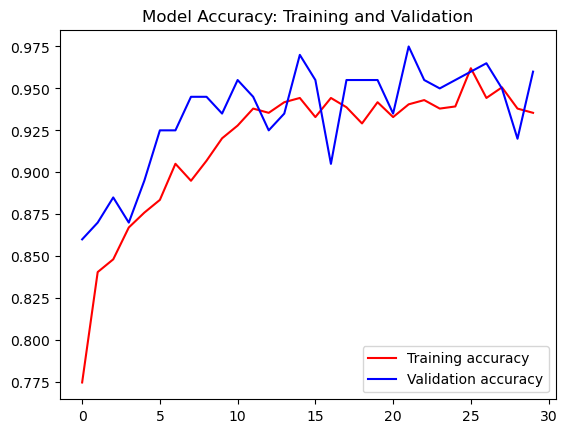

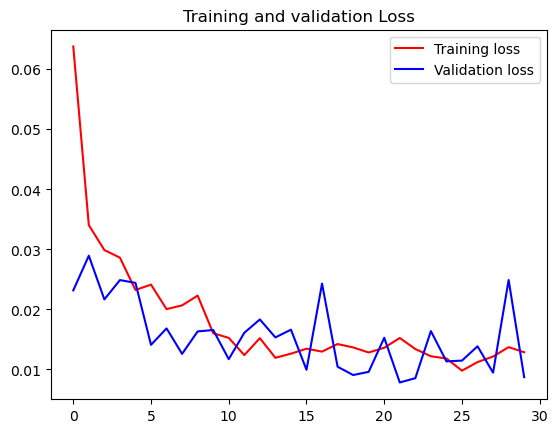

<Figure size 640x480 with 0 Axes>

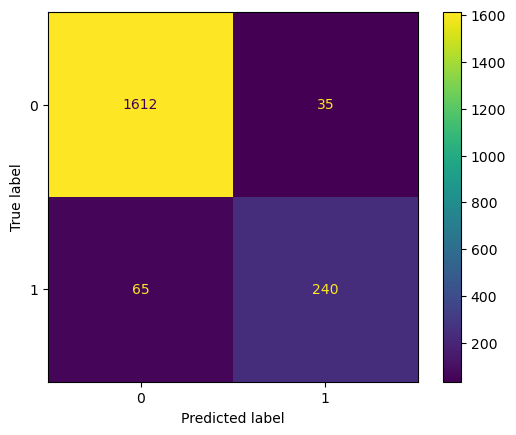


               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1647
           1       0.87      0.79      0.83       305

    accuracy                           0.95      1952
   macro avg       0.92      0.88      0.90      1952
weighted avg       0.95      0.95      0.95      1952

Sensitivity: 0.787 Specificity: 0.979 Precision: 0.947 ROC_AUC_SCORE: 0.98



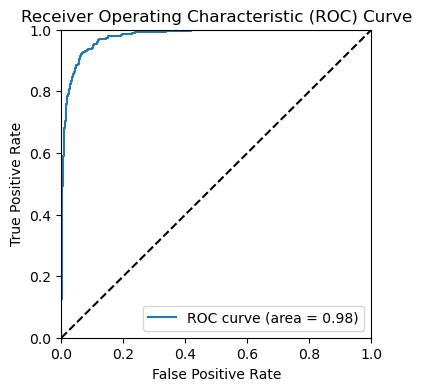

Validation complete...
Traning for Fold: 2
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9329
Epoch 1: val_accuracy improved from -inf to 0.94000, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_2.hdf5
79/79 [==============================] - 93s 575ms/step - loss: 0.0148 - accuracy: 0.9329 - val_loss: 0.0179 - val_accuracy: 0.9400 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9392
Epoch 2: val_accuracy did not improve from 0.94000
79/79 [==============================] - 39s 495ms/step - loss: 0.0153 - accuracy: 0.9392 - val_loss: 0.0159 - val_accuracy: 0.9300 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learni

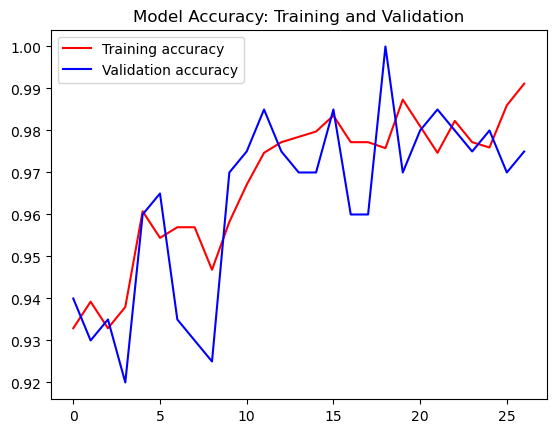

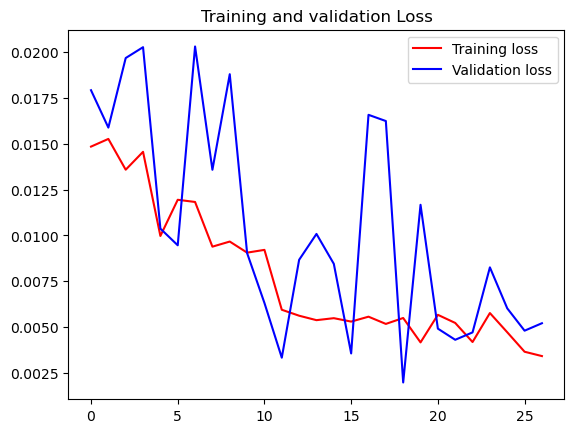

<Figure size 640x480 with 0 Axes>

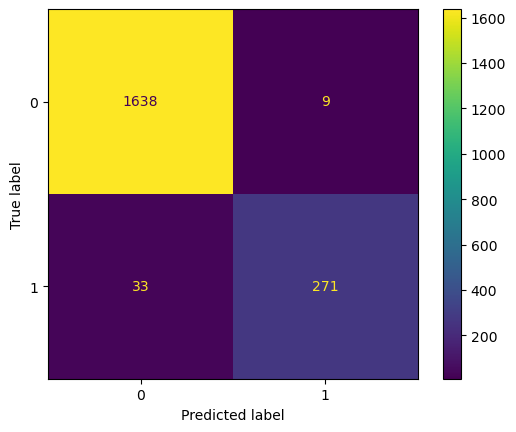


               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1647
           1       0.97      0.89      0.93       304

    accuracy                           0.98      1951
   macro avg       0.97      0.94      0.96      1951
weighted avg       0.98      0.98      0.98      1951

Sensitivity: 0.891 Specificity: 0.995 Precision: 0.978 ROC_AUC_SCORE: 0.994



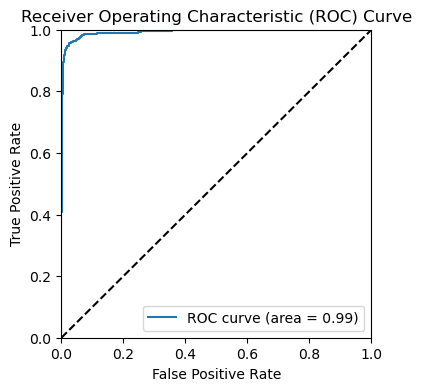

Validation complete...
Traning for Fold: 3
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9608
Epoch 1: val_accuracy improved from -inf to 0.95500, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_3.hdf5
79/79 [==============================] - 91s 552ms/step - loss: 0.0106 - accuracy: 0.9608 - val_loss: 0.0109 - val_accuracy: 0.9550 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9785
Epoch 2: val_accuracy improved from 0.95500 to 0.99000, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_3.hdf5
79/79 [==============================] - 41s 524ms/step - loss: 0.0065 - accuracy: 0.9785 - val_loss: 0.0043 - val_accu

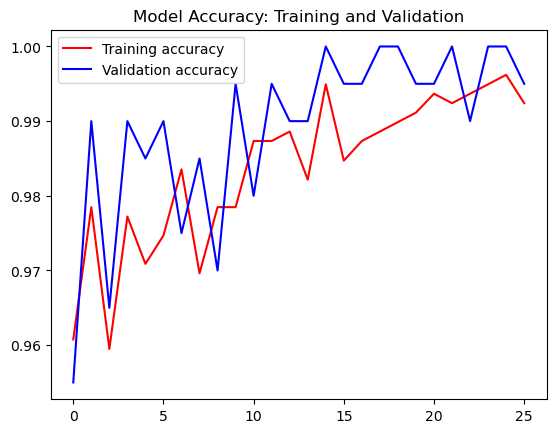

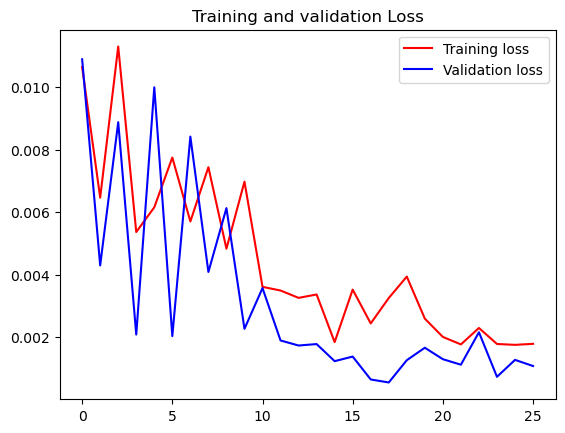

<Figure size 640x480 with 0 Axes>

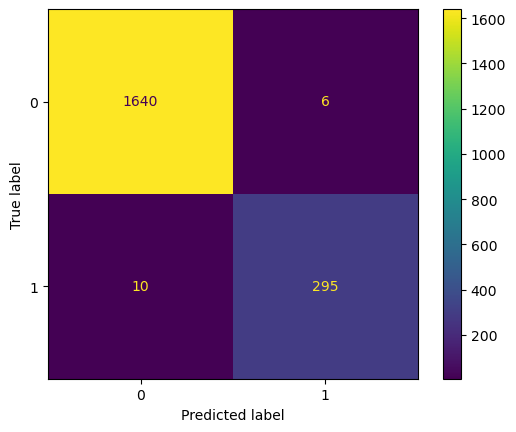


               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1646
           1       0.98      0.97      0.97       305

    accuracy                           0.99      1951
   macro avg       0.99      0.98      0.98      1951
weighted avg       0.99      0.99      0.99      1951

Sensitivity: 0.967 Specificity: 0.996 Precision: 0.992 ROC_AUC_SCORE: 1.0



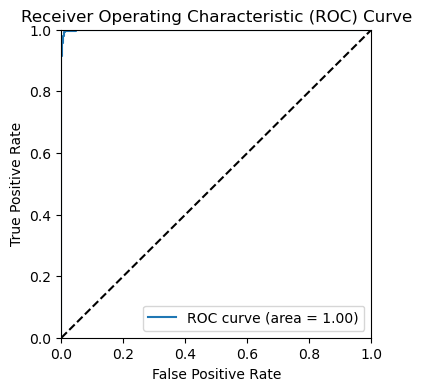

Validation complete...
Traning for Fold: 4
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9823
Epoch 1: val_accuracy improved from -inf to 0.99500, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_4.hdf5
79/79 [==============================] - 93s 575ms/step - loss: 0.0050 - accuracy: 0.9823 - val_loss: 0.0015 - val_accuracy: 0.9950 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9848
Epoch 2: val_accuracy did not improve from 0.99500
79/79 [==============================] - 41s 520ms/step - loss: 0.0041 - accuracy: 0.9848 - val_loss: 0.0018 - val_accuracy: 0.9900 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learni

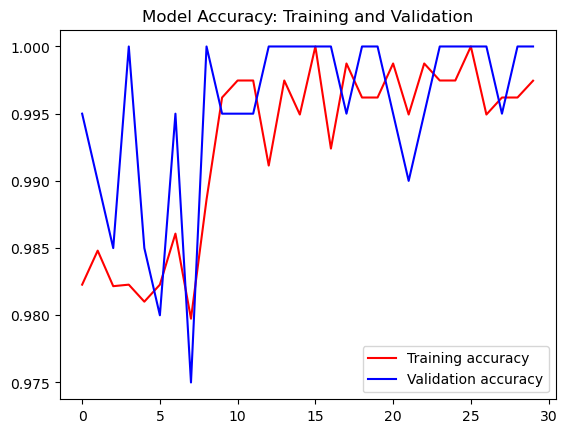

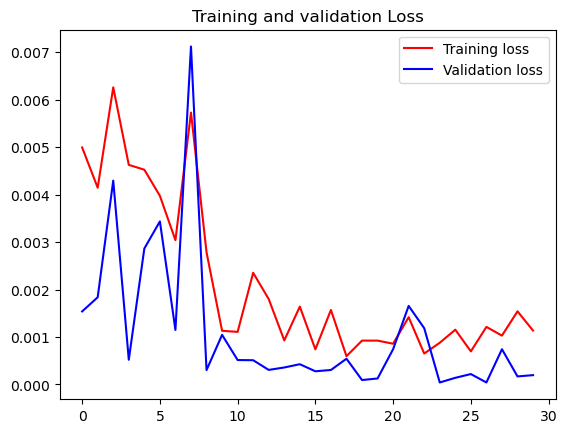

<Figure size 640x480 with 0 Axes>

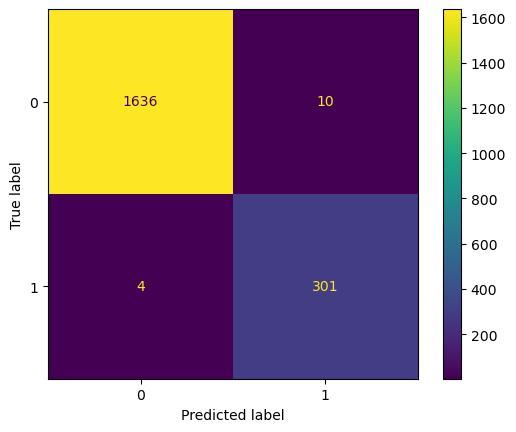


               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1646
           1       0.97      0.99      0.98       305

    accuracy                           0.99      1951
   macro avg       0.98      0.99      0.99      1951
weighted avg       0.99      0.99      0.99      1951

Sensitivity: 0.987 Specificity: 0.994 Precision: 0.993 ROC_AUC_SCORE: 1.0



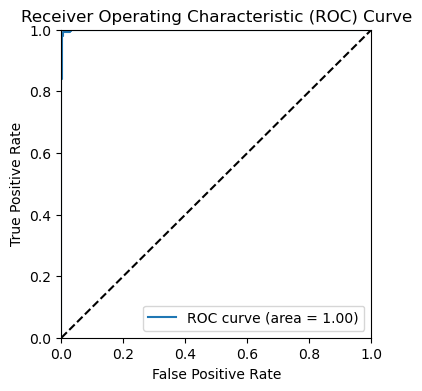

Validation complete...
Traning for Fold: 5
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9924
Epoch 1: val_accuracy improved from -inf to 0.99500, saving model to /kaggle/working/model/seb_vs_nev_aug/model_fold_5.hdf5
79/79 [==============================] - 93s 575ms/step - loss: 0.0037 - accuracy: 0.9924 - val_loss: 0.0023 - val_accuracy: 0.9950 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9722
Epoch 2: val_accuracy did not improve from 0.99500
79/79 [==============================] - 38s 486ms/step - loss: 0.0068 - accuracy: 0.9722 - val_loss: 0.0017 - val_accuracy: 0.9950 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learni

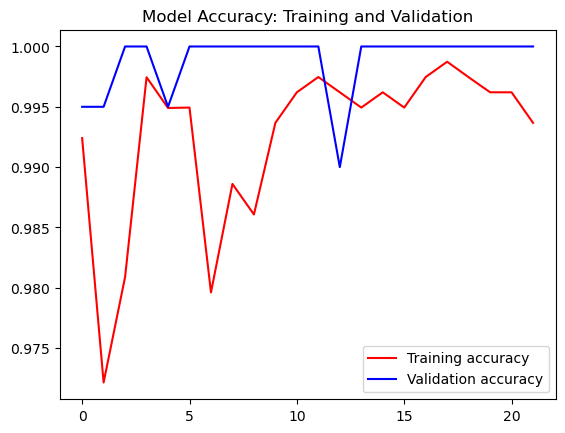

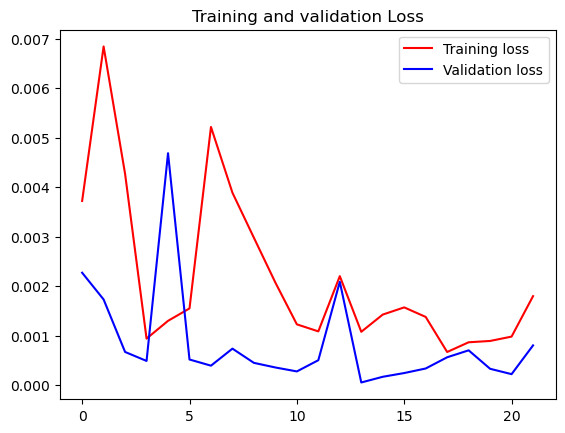

<Figure size 640x480 with 0 Axes>

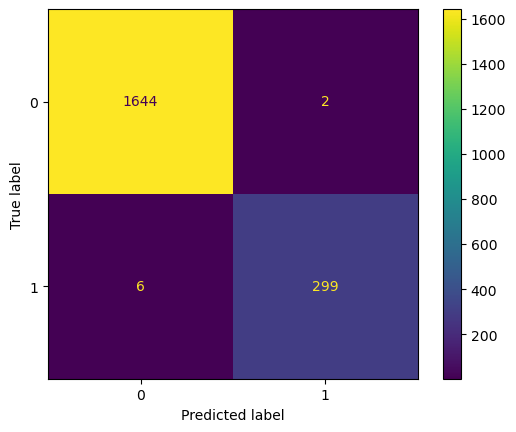


               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1646
           1       0.99      0.98      0.99       305

    accuracy                           1.00      1951
   macro avg       0.99      0.99      0.99      1951
weighted avg       1.00      1.00      1.00      1951

Sensitivity: 0.98 Specificity: 0.999 Precision: 0.996 ROC_AUC_SCORE: 1.0



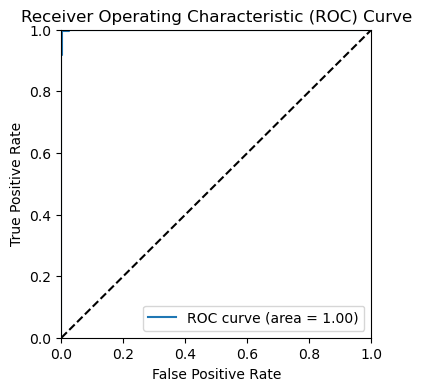

Validation complete...


In [ ]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
#     print(f"Fold {i}:")
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)
    
    #Plotting train and validation accuracy and loss
    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [13]:
test_dir

'/content/drive/MyDrive/msc_project/test_splited'

In [17]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 427s 874ms/step


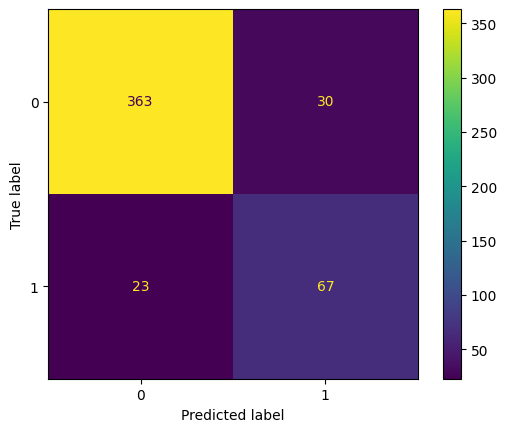


               precision    recall  f1-score   support

           0       0.94      0.92      0.93       393
           1       0.69      0.74      0.72        90

    accuracy                           0.89       483
   macro avg       0.82      0.83      0.82       483
weighted avg       0.89      0.89      0.89       483

Sensitivity: 0.744 Specificity: 0.924 Precision: 0.894 ROC_AUC_SCORE: 0.921



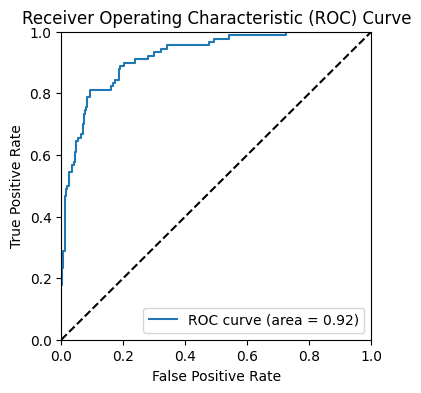

Testing Complete
Test using model 2
483/483 [==============================] - 423s 875ms/step


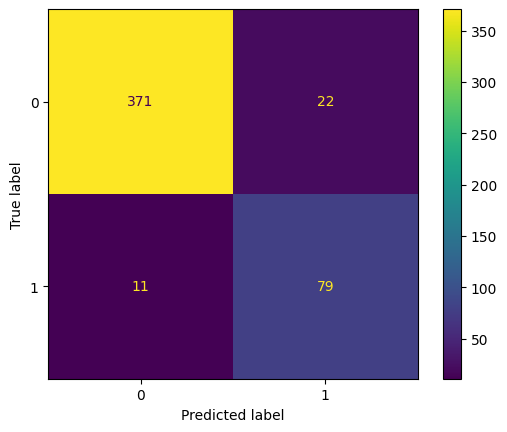


               precision    recall  f1-score   support

           0       0.97      0.94      0.96       393
           1       0.78      0.88      0.83        90

    accuracy                           0.93       483
   macro avg       0.88      0.91      0.89       483
weighted avg       0.94      0.93      0.93       483

Sensitivity: 0.878 Specificity: 0.944 Precision: 0.936 ROC_AUC_SCORE: 0.948



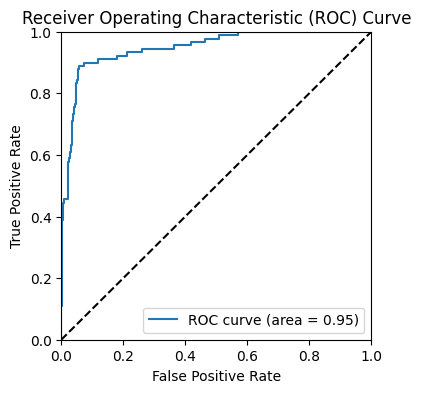

Testing Complete
Test using model 3
483/483 [==============================] - 423s 876ms/step


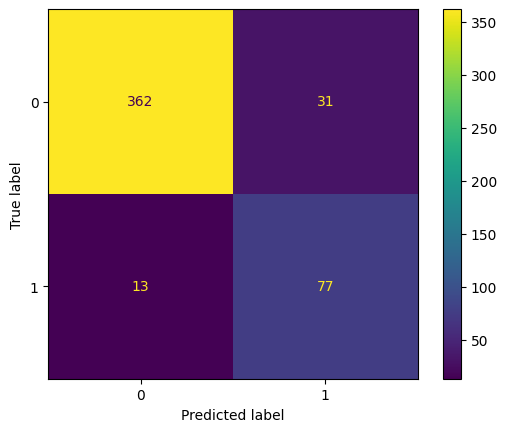


               precision    recall  f1-score   support

           0       0.97      0.92      0.94       393
           1       0.71      0.86      0.78        90

    accuracy                           0.91       483
   macro avg       0.84      0.89      0.86       483
weighted avg       0.92      0.91      0.91       483

Sensitivity: 0.856 Specificity: 0.921 Precision: 0.918 ROC_AUC_SCORE: 0.948



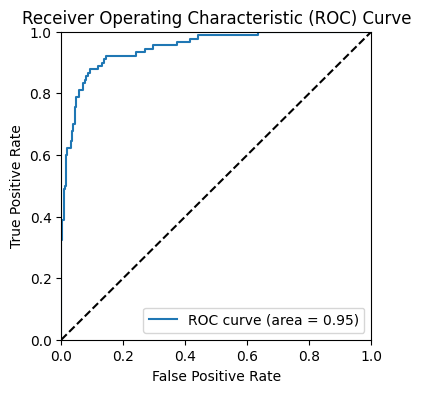

Testing Complete
Test using model 4
483/483 [==============================] - 427s 884ms/step


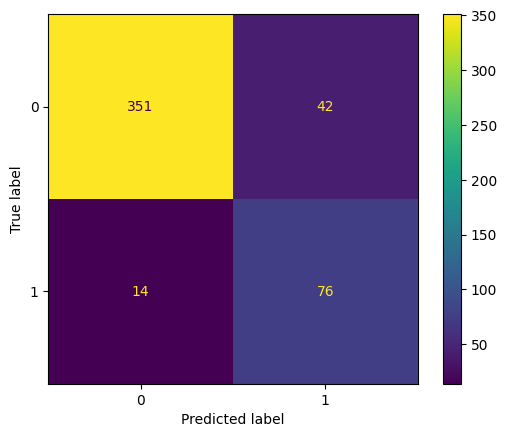


               precision    recall  f1-score   support

           0       0.96      0.89      0.93       393
           1       0.64      0.84      0.73        90

    accuracy                           0.88       483
   macro avg       0.80      0.87      0.83       483
weighted avg       0.90      0.88      0.89       483

Sensitivity: 0.844 Specificity: 0.893 Precision: 0.902 ROC_AUC_SCORE: 0.949



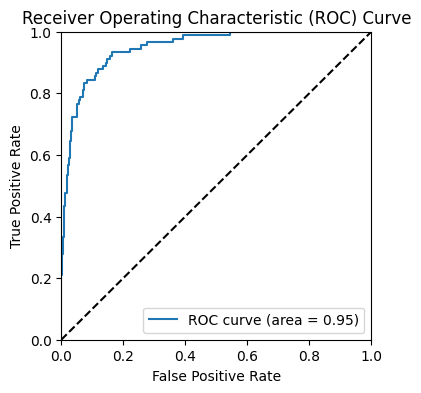

Testing Complete
Test using model 5
483/483 [==============================] - 430s 890ms/step


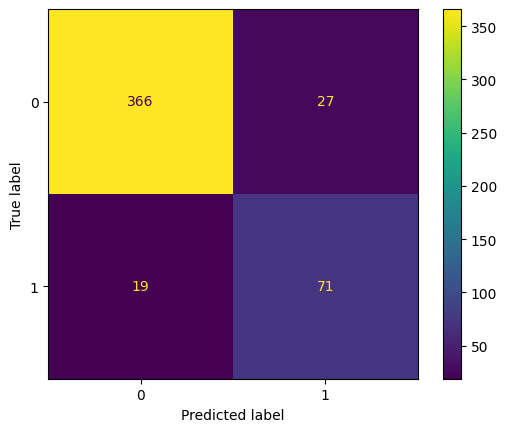


               precision    recall  f1-score   support

           0       0.95      0.93      0.94       393
           1       0.72      0.79      0.76        90

    accuracy                           0.90       483
   macro avg       0.84      0.86      0.85       483
weighted avg       0.91      0.90      0.91       483

Sensitivity: 0.789 Specificity: 0.931 Precision: 0.909 ROC_AUC_SCORE: 0.946



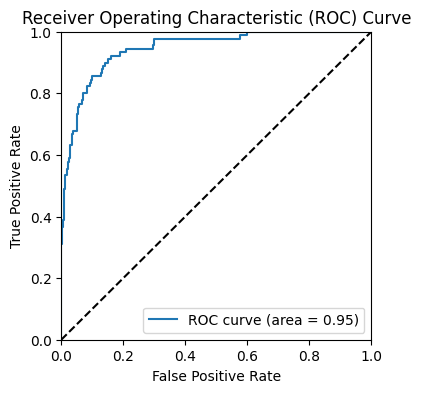

Testing Complete


In [18]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")